<a href="https://colab.research.google.com/github/deborapcopa/eci2019-nlp/blob/master/%5Beditable_DCopa%5D_C%C3%B3digo_005_(features_corregidos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Montar google Drive
from google.colab import drive
drive.mount('/content/drive')
# Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly


Mounted at /content/drive


#1: Archivos y paquetes

In [ ]:
# Paquetes de para graficar cerebros 3D y conectividades
#!pip install nilearn
#!pip install --upgrade --pre nilearn

In [ ]:
################################################################################
#                                 PAQUETES 
################################################################################

import scipy.io as spio   #cargar matlab
import pandas as pd       #DB
import matplotlib.pyplot as plt   # gráfico de datos
import numpy as np        # matemática, simil maltab 
import csv

from sklearn import tree  #machine learning
from sklearn.ensemble import BaggingClassifier #?
from sklearn.linear_model import LogisticRegression # Modelo Regresión Logística
from sklearn.ensemble import AdaBoostClassifier # Modelo AdaBoost
from sklearn.ensemble import RandomForestClassifier # Modelo Random Forest
from xgboost import XGBClassifier # Modelo XGBoost
from sklearn.ensemble import GradientBoostingClassifier # Modelo Gradient Boost
from sklearn.ensemble import ExtraTreesClassifier #?
import lightgbm as lgb #?
from sklearn.ensemble import VotingClassifier #?
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,mutual_info_classif
from sklearn.metrics import roc_auc_score #https://scikit-learn.org/stable/modules/model_evaluation.html    
# accuracy (precision recall, sensitivity , speciﬁcity )
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold # Selección de mejores features 
from xgboost import plot_importance #?

# Evitar acumulación de mensajes de warning en el display
import warnings  
warnings.filterwarnings("ignore")



# 2: Modelo



In [ ]:
################################################################################
#                                 MODELO 
################################################################################

def get_model2():
  # Ensemble Learning 
  rf = RandomForestClassifier(random_state=1)
  model = rf

  return model

In [ ]:
################################################################################
#                                 MODELO 
################################################################################

def get_model():
  # Ensemble Learning 
  gbm = GradientBoostingClassifier(random_state=1)
  model = gbm

  return model


# 3: Dataset

In [ ]:
################################################################################
#                               LOAD DATASET 
################################################################################

def load_dataset(week, qids_ruta):

  # posible weeks
  # week: 'week0', 'week1', 'week2', 'week3', 'week5', 'week12', 'week24'

  #*************************** cargamos outcomes *******************************
  
  #Load
  #df = pd.read_excel('drive/My Drive/Colab Notebooks/QIDS.xlsx', sheet_name='Sheet1')
  T = pd.read_excel(qids_ruta, sheet_name ='Sheet1')

  # yo tengo 16 fmri, en el excel son 19 QIDs y en paper dice 12 pacientes
  # Suj = np.array(['S01', 'S02', 'S03', 'S04', 'S05', 'S07', 'S08', 'S09', 'S10', 'S13', 'S14', 'S15', 'S16', 'S18', 'S19', 'S20'])
  # NoSuj = np.array(['S06','S11', 'S12', 'S17'])

  # Remove patients without fmri
  T = T[T['Subject (Robin)'] !='S06']
  T = T[T['Subject (Robin)'] !='S11']
  T = T[T['Subject (Robin)'] !='S12']
  # (S17 no tiene daros de fMRI, por eso no se quita de la matriz)

  # get the values for a given column
  switcher = {
    'week0'  : 'response',
    'week1'  : 'response.1',
    'week2'  : 'response.2',
    'week3'  : 'response.3',
    'week5'  : 'response.4',
    'week12' : 'response.5',
    'week24' : 'response.6', 
  }
  
  response_select = switcher.get( week, -1)   
  
  if response_select == -1: 
    print('Error al cargar dataset!!')
    return -1
  else:
    return T[response_select].values 



# 4: Labels

In [2]:
def get_labels_from_sheets(zona):
  # autorizar para acceder al drive para leer documentos
  from google.colab import auth
  auth.authenticate_user()
  import gspread

  from oauth2client.client import GoogleCredentials
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  etiquetas=np.asarray([-1]) #Valor por defecto. FLAG: Si no existe zona.

  # leer documento en la dirección especificada
  wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1wJQegcqOaxMJ5VDwe3qIIQFDtItMu-WJ_Wj0d4Pev_Y/edit#gid=1408400452')
  N = len(wb.worksheets())

  for i in range(0,N): #Busca hoja por hoja del excel la etiqueta "zona" ingresada en todas las columnas
    hoja=wb.get_worksheet(i) #se queda con una hoja
    df_contenido = pd.DataFrame(hoja.get_all_records())#transforma a df
    x=df_contenido.columns#nombres de las colunas
    if zona in x: #esta la etiqueta en el df?
      a=df_contenido[zona] #columna elegida en forma de df
      etiquetas=np.asarray(a[df_contenido[zona] !=''].values)
      break
  return etiquetas

In [ ]:
################################################################################
#                             LABELS (ETIQUETAS)
################################################################################

# Función para obtener los labels a partir del codigo nuevo 
# (puede requerir codigo del anterior si se quieren muchisimos labels)
#-------------------------------------------------------------------------------

# zones debe ser un str ('string') o una lista de str (['string1','string2'])
# con los nombres clave de cada zona
# la salida es una lista de numeros de los labels (lab-1) o codigo -1 (all labels)
# o codigo -2 (error)

def get_labels(zones):
    # si "zones" no es una lista (o sea, es un str), la convierto en lista
  if isinstance(zones, list) == False:
    zones = [zones]

  # Cargamos el primer label ingresados en "zones" 
  labels = get_labels_from_sheets(zones[0])    # leemos label 
# Cargamos y acumulamos los restantes labels (si "zones" posee mas de uno)
  if len(zones) > 1:  # zones tiene mas de un elemento?  
    for i in range(1,len(zones)):
      newlabs = get_labels_from_sheets( zones[i])       # leemos label
      labels = np.concatenate( (labels, newlabs) )  # concatemaos labels

  # Chequeamos si las zonas son correctas, sino devuelve codigo de error (-1)
  for i in range(0,len(labels)):
    if labels[i]==-1: 
       print('No se reconoce alguna de las zonas ingresadas!')
       return -1  

  # retorna:
  # [...] labels elegidos
  # -1 codigo de error (label erroneo)
  return np.unique(np.asarray(labels)-1).astype(int)

PAra los indices de las etiquetas resultantes


# 5: Features

In [ ]:
################################################################################
#                                FEATURES
################################################################################


# Función que devulve los features dado los 'labels' (filas) contra 'todos' (columnas)
#-------------------------------------------------------------------------------

def get_features(labs_row, labs_col, correl_ruta):

  #**************** Load matrix Autocorrelation from each patient ***************

  mat = spio.loadmat(correl_ruta)
  cORR = mat['CORR']
  [rhox, rhoy, nsuj] = cORR.shape #[401 401 16]
  #print(rhox, rhoy, nsuj)
  #******************* Reducción de la matriz de correlación ********************
 
  # obtenemos indices de una matriz de 401 x 401 quitando su diagonal
  One = np.ones([rhoy,rhoy])

  np.fill_diagonal(One, 0)

  # obtenemos indices para os lables de interes. Tmabien eliminamos los de la diag.
  Onelab = One[labs_row, :]
  Onelab = Onelab[:, labs_col]
  Ilab = np.nonzero(Onelab) 

  # Primer matriz de features
  R = cORR[labs_row,:,0]  # matriz de correlación R temporal paciente 0   
  R = R[:, labs_col]  
  X = R[Ilab]             # matriz de correlación reducida (sin ceros)     [1xfeat]     porque en 2 partes?

  # guardamos la matriz de features para el resto de los pacientes [16xfeat]
  for i in range(1, nsuj):
      R = cORR[labs_row,:,i]  # matriz de correlación paciente 0 
      R = R[:, labs_col]
      newrow = R[Ilab]
      X = np.vstack([X, newrow])

  #********* Elimino los features que tienen NAN para algun paciente *************
  m = np.isnan(X)
  M = 1*m
# aca miro que filas tienen nan
  A = np.asarray([sum([row[i] for row in M]) for i in range(0,len(M[0]))])       #np.sum(M,axis=0).tolist() y despues
  #B = np.sum(M,axis=0).tolist()
  X = X[:,A==0] # evalua en las columnas(features) que no sumo ningun NAN

  # Etiquetas de referencia de los features elegidos
  labmax=rhoy #401
  labfull = np.linspace(1, labmax, num = labmax) 
  full_row, full_col = np.meshgrid(labfull, labfull, sparse=False, indexing='ij')

  LABrow = full_row[labs_row,:]
  LABrow = LABrow[:,labs_col]

  LABcol = full_col[labs_row,:]
  LABcol = LABcol[:,labs_col]

  LABcol_out = LABcol[Ilab] 
  LABrow_out = LABrow[Ilab] 
#le saco los NAN y devuelvo los indices fila y columna
  return X, LABrow_out[A==0], LABcol_out[A==0]

# 6: Model training function

In [ ]:
################################################################################
#                 Funcion para el entrenamiendo del modelo
################################################################################
from sklearn.metrics import roc_curve
from scipy import interp
from sklearn.metrics import plot_roc_curve


def func(skf, model, X, y, folds, Nf):

  ##y_pred = []

  aucs = np.zeros(folds)
  accu = np.zeros(folds)
  prec = np.zeros(folds)
  prec = np.zeros(folds)

  mean_auc = []
  sample, nfT = X.shape
  
  fimportances =[ ] #np.zeros([folds, Nf])
  frank=[] #np.zeros([folds, Nf])  #ranking de features seleccionados [1x20]
  #print(fimportances.shape)

 
  i = 0
  for train_i, test_i in skf.split(X, y):

      X_train, X_test = X[train_i], X[test_i]
      y_train, y_test = y[train_i], y[test_i]
      #print('test_i ',test_i)

      #skb = SelectKBest(mutual_info_classif, k=Nf) #Mutual information for a discrete target.
      skb = SelectKBest(f_classif, k = Nf) #ANOVA F-value between label/feature for classification tasks.
      X_new = skb.fit_transform(X_train, y_train)
      rank = skb.get_support(True)

      model.fit(X_new, y_train) # entrenamiento
      
      probas_ = model.predict_proba( X_test[:,rank] ) 
      scores = model.predict(X_test[:,rank]) #  Predict class for X.
      accu[i] = accuracy_score(y_test, scores , normalize=True, sample_weight=None)#REVISAR !!!
      prec[i] = average_precision_score(y_test, scores, average='macro', pos_label=1, sample_weight=None)
      aucs[i] = roc_auc_score( y_test ,  probas_[:, 1])

      fimportances = np.append(fimportances, model.feature_importances_)
      
      frank = np.append(frank, rank) #ver si cuenta desde 0
      
      i=i+1

  # valores medio de las metricas obtenidas en los 5 folds
  mean_auc = np.mean(aucs, axis=0)
  mean_accu = np.mean(accu, axis=0)
  mean_prec = np.mean(prec, axis=0)
  
  return fimportances, frank, mean_auc, mean_accu, mean_prec
#    fimport_, frank, mean_auc_, var_auc_, mean_accu_, var_accu_, mean_prec_, var_prec_  


# 7: Cross-validation

In [ ]:
# DATOS Y REFERENCIAS
######################

# Respuestas de cada semana luedo de la 2da dosis:
# Week 0:  'response' 
# Week 1:  'response.1'
# Week 2:  'response.2'
# Week 3:  'response.3'
# Week 5:  'response.4'
# Week 12: 'response.5'
# Week 14: 'response.6'

# ------- Zonas del cerebro predictivas (individuales)
# Amigdala:           'amg' 
# Hipocampo:          'hipo' 
# Anterior Cingulate: 'antcyg'
# Cingulate gyrus:    'cyngys'
# Limbico:            'limbic' 
# Frontal:            'frontal'
# .....
# PFC:                'pfc' 

# SIMULACIONES
#---------------
# x FRONTAL_ALL
# x PFC_ALL
# x HIPO_ALL
# x AMG_ALL
# x AMG_FRONTAL <--
# x ANTCYG_ALL
# x LIMBIC_ALL
# x SFG_ALL
# x MFG_ALL
# x IFG_ALL
# X ANTCYG_FRONTAL
# x ALL_ALL
# x PFC_AMGHIPO
# x HIPO_FRONTAL (L)
# LIMBIC_FRONTAL (D)
# LIMBIC_PFC (L)
# DMN_DMN (D)

## 5/10
# xprimary_visual	xextra_striate_visual	xauditory	sensorimotor	xdmn	executive_motor	xsalience
# Amigdala RL	Cingulum Ant RL	Cingulum Mid RL	Cingulum Post RL	Frontal RL	Hipocampo RL	Insula RL	Parahipocampo RL	Precuneus RL
"""
Cosas de Stratified 
https://www.google.com/url?q=https://stackoverflow.com/questions/59619291/when-should-i-shuffle-in-stratifiedkfold&sa=D&source=hangouts&ust=1601363398793000&usg=AFQjCNFmYu4APdnVcbyMYbOHnCxHcUTiXg
"""

'\nCosas de Stratified \nhttps://www.google.com/url?q=https://stackoverflow.com/questions/59619291/when-should-i-shuffle-in-stratifiedkfold&sa=D&source=hangouts&ust=1601363398793000&usg=AFQjCNFmYu4APdnVcbyMYbOHnCxHcUTiXg\n'

In [ ]:
#=========================== graficos editados por DEBORA ======================
from matplotlib import pyplot as pl

def results_plot_auc(resp, Nff, n, drive_name, id_carpeta ):

  # vamos a guardar en una matriz: 
  # filas = best features (Nf)
  # columnas = responses
  R_PVALUE = np.zeros([len(Nff),len(resp)])
  R_AUC = np.zeros([len(Nff),len(resp)])
  R_STD_AUC = np.zeros([len(Nff),len(resp)])
  R_AUC_S = np.zeros([len(Nff),len(resp)])
  R_STD_AUC_S = np.zeros([len(Nff),len(resp)])
  R_ACCU = np.zeros([len(Nff),len(resp)])
  R_STD_ACCU = np.zeros([len(Nff),len(resp)])
  R_PREC = np.zeros([len(Nff),len(resp)])
  R_STD_PREC = np.zeros([len(Nff),len(resp)])
  R_ITER = np.zeros([len(Nff),len(resp)])
  R_NF = np.zeros([len(Nff),len(resp)])
  R_RESPONSE = []

  for i in range(0,len(resp)):
    for j in range(0,len(Nff)):
      
      # Lectura de datos csv reportados
      k = 0
      datos = np.zeros(11)
      
      dir_name = drive_name +'/'+ id_carpeta +'/'
      file_name = 'Reporte_' + resp[i] + '_' + str(int(Nff[j])) + '.csv'
      
      #file_reported = 'Reportes ('+ id_carpeta +')/Reporte_' + resp[i] + '_' + str(int(Nff[j])) + '.csv'
      drive_name = '/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/Reportes (creado dic 2020)/'
# ruta al drive (la nueva)
      drive_name = '/content/drive/My Drive/Colab Notebooks/Debora (cont)/Reportes RF (creado mar 2021)'
      with open(dir_name + file_name) as File:#'/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/' + file_reported, newline='') as File:  
          reader = csv.reader(File)
          for row in reader:
            if (k == 0 or k == 1):
              k=k
            else:  
              datos[k-2] = row[1]
              #print(row[0],row[1])
            k = k + 1

      # carga de datos
      R_RESPONSE.append(resp[i])
      R_PVALUE[j,i]     = datos[0]
      R_AUC[j,i]        = datos[1]
      R_STD_AUC[j,i]    = datos[2]#
      R_AUC_S[j,i]      = datos[3]
      R_STD_AUC_S[j,i]  = datos[4]
      R_ACCU[j,i]       = datos[5]
      R_STD_ACCU[j,i]   = datos[6]
      R_PREC[j,i]       = datos[7]
      R_STD_PREC[j,i]   = datos[8]
      R_NF[j,i]         = datos[9]
      R_ITER[j,i]       = datos[10]


  # plots
  for b in range(0,len(resp)):
    fig = plt.figure()
    plt.title('Response: {} con n={} iteraciones'.format(resp[b],n))
    
    plt.axhline(y=0.5, c='blue', linestyle='dashed', label="AUC Chance")
    plt.axhline(y=0.05, c='green', linestyle='dashed', label="p_{max}-value")
    plt.plot(R_NF[:,b], R_AUC[:,b], c='blue', label='AUC')
    plt.plot(R_NF[:,b], R_PVALUE[:,b], c='green', label='p-value')
    
    #pl.fill_between(R_NF[:,b], R_AUC[:,b]-R_STD_AUC[j,b], R_AUC[:,b]+R_STD_AUC[j,b],
    #alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    plt.ylim((0,1))
    plt.grid(color='gray', linestyle=':', linewidth=1)
    plt.legend()
    plt.xlabel('Best features number')
    plt.ylabel('Metric [0,1]')
    fig.patch.set_facecolor('xkcd:white')
    plt.savefig(dir_name +  'Plot_' + resp[b] +'_n' + str(n) + '.png' )
    pl.show()

## Script 

In [ ]:
from sklearn.utils import shuffle
################################################################################
#                     Run classifier with cross-validation 
################################################################################

# folders
drive_qids = '/content/drive/My Drive/Colab Notebooks/QIDS.xlsx'
drive_corr = '/content/drive/My Drive/Colab Notebooks/CORR.mat'
# ruta al drive (la de siempre)
reportes_folder = '/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/Reportes (creado dic 2020)'#'Reportes (creado sep 2020)'
# ruta al drive (la nueva)
reportes_folder = '/content/drive/My Drive/Colab Notebooks/Debora (cont)/Reportes RF (creado mar 2021)'

write_file = 1
write_fimportances = 1

id_carpeta = 'SMN_ALL'#'SAL '#carpeta donde se tiran los reportes(crear a mano la carpeta primero)
regions_row = 'smn' #Xsmn_e	Xdmn_e	Xexecutive_motor_e	xsalience_e
regions_col = 'all'
weeks =['week0','week1','week2','week3','week5','week12','week24']# 
weeks =['week24']# 

folds = 5  # numero de folds en la cross-validation
n = 1000    # numero de iteraciones para la cross-validation con permutaciones
Nff = [1, 2, 4, 8, 16, 32, 64, 128, 192, 256] #cant de k best features dentro de cada fold
Nff = [ 8, 16, 32, 64, 128, 192, 256] #cant de k best features dentro de cada fold

# Parametros de la simulacion
#-----------------------------

for r in range(0,len(weeks)):
  for N in range(0,len(Nff)):
 
    week = weeks[r]  # respuesta de la semana correspondiente

    #regiones = regiones_elejidas       # region/es de interes para generar freatures
    Nf = Nff[N]  # Numero de features en la cross.validation (select k-best)
      # numeroo de archivo de salida ('Reporte_{num}.csv')
    
    #Nf=nnf[r]
    
    # Inicializacion de funciones
    #---------------------------------------

    # seteamos los target de la respuesta asociada a cada semana
    Y = load_dataset(week, drive_qids)
    if Y.any == -1: break   #  corta si hubo un error

    # obtenemos objeto del modelo a ultilizar (GMB)
    gbm = get_model2()
    
    # obtenemos vector de labels asociados a las zonas (label = [LABEL-1])
    labs_row = get_labels(regions_row)
    labs_col = get_labels(regions_col)
    if labs_row.any == -1 or labs_col.any == -1: break  #  corta si hubo un error 

    # obtenemos los features (desenrrollados), su tamaño y el tamaño de la muestra
    X, Lrow, Lcol = get_features(labs_row, labs_col, drive_corr)
    #X, Lrow, Lcol = get_features([35-1], [94-1], drive_corr)

    n_suj, n_feat = X.shape
  
    # Inicializacion de variables y matrices
    #---------------------------------------
    fimport     = np.zeros(n_feat)     # features importances
    frank       = np.zeros([folds*Nf]) # ranking de features seleccionados [folds*Nf]
    mean_auc    = np.zeros(n)
    mean_auc_s  = np.zeros(n)
    mean_accu   = np.zeros(n)
    mean_accu_s = np.zeros(n)
    mean_prec   = np.zeros(n)
    mean_prec_s = np.zeros(n)

    # Iteraciones para la cross-validation con n permutaciones
    #---------------------------------------------------------
    print(' -------------------------------------------------------------------------')
    print(' Respuesta: ', week,'     |       Nf : ',Nf,'')
    print(' -------------------------------------------------------------------------')
  
    for i in range(0, n):
        print("\riteracion {} de {}    ".format(i+1, n), flush=True,end="")

        Y_s = shuffle(Y) 
        #Y_s = shuffle(Y, random_state=1)

        #YY_s = np.vstack((Y, Y_s)).T        # y = [Y Y_s]

        # Estratificado 
        skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state=None) # chequar qué es lo que mezcla
        
        # i-cross-validation y metricas obtenidas para los outcomes Verdaderos
        fimport_, frank, mean_auc_, mean_accu_, mean_prec_ = func(skf, gbm, X, Y, folds, Nf)

        # USAR MISMO SKF QUE EL NO-SUFLLE???????????
        # skf_s = StratifiedKFold(n_splits = folds, shuffle = True, random_state=None) # chequar qué es lo que mezcla

        # i-cross-validation y metricas obtenidas para los outcomes Shuffleados  
        fimport_s_, frank_s, mean_auc_s_, mean_accu_s_, mean_prec_s_ =  func(skf, gbm, X, Y_s, folds, Nf)
 
        # Metricas promedio para la i-esima iteracion
        mean_auc[i]    = mean_auc_
        mean_auc_s[i]  = mean_auc_s_
        mean_accu[i]   = mean_accu_
        mean_accu_s[i] = mean_accu_s_
        mean_prec[i]   = mean_prec_
        mean_prec_s[i] = mean_prec_s_
        
        # sumamos los puntajes de los features importances
        for j in range( 0, folds*Nf ):
          fimport[ int(frank[j]) ] = fimport[ int(frank[j]) ] + fimport_[j]
        
    #print(fimport)

    # promedio de los puntajes de los features importances
    fimport = fimport / (folds * n)
    
    # ordenamiento de los features importances 
    fimport_sort = np.sort(fimport)[::-1]
    argf = np.argsort(fimport)[::-1]

    # ordenamiento de los labels (row,col) asociados a cada feature
    frow = Lrow[argf]
    fcol = Lcol[argf]
    
    # p-value:
    #The p-value, which approximates the probability that the score would be obtained by chance. This is calculated as:
    #(C + 1) / (n_permutations + 1)
    #Where C is the number of permutations whose score >= the true score.
    pvalue = np.sum([(mean_auc_s > mean_auc)*1])/n
    
    # scores

    AUC       = np.mean(mean_auc)
    AUC_S     = np.mean(mean_auc_s)
    STD_AUC   = np.std(mean_auc)
    STD_AUC_S = np.std(mean_auc_s)

    ACCU       = np.mean(mean_accu)
    ACCU_S     = np.mean(mean_accu_s)
    STD_ACCU   = np.std(mean_accu)
    STD_ACCU_S = np.std(mean_accu_s) 

    PREC       = np.mean(mean_prec)
    PREC_S     = np.mean(mean_prec_s)
    STD_PREC   = np.std(mean_prec)
    STD_PREC_S = np.std(mean_prec_s)
 
    # save results metrics
    if write_file == 1:#si 1 escribe archivo de reporte
      f = open (reportes_folder + '/'+ id_carpeta + '/'+ 'Reporte_'+ week +'_' + str(Nf) + '.csv','w')
      f.write("Parameter, Value\nWeek,{}\n p-value,{}\n AUC,{}\nstd AUC,{}\nAUC Shuffle,{}\nstd AUC Shuffle,{}\nAccuracy,{}\nstd Accuracy,{}\nPrecision,{}\nstd Precision,{}\nBest features Number,{}\nIterations number,{}"
      .format(week, pvalue, AUC, STD_AUC, AUC_S, STD_AUC_S, ACCU, STD_ACCU, PREC, STD_PREC, Nf, n))
      f.close()



    # save features importances ordenada
    if write_fimportances == 1: #si 1 escribe archivo de lista de features y su importancia
      f = open (reportes_folder + '/'+ id_carpeta + '/'+ 'Reporte_FeatImp_'+ week +'_' + str(Nf) + '.csv','w')
      f.write("Row label, Col label, Importances \n")
      for k in range(0,200):
        f.write('{},{},{}\n'.format(frow[k], fcol[k], fimport_sort[k]))
      f.close()
    '''
    # save features importances
    if write_fimportances == 1: #si 1 escribe archivo de lista de features y su importancia
      f = open (reportes_folder + '/'+ id_carpeta + '/'+ 'Reporte_FeatImp_orign_'+ week +'_' + str(Nf) + '.csv','w')
      f.write("Row label, Col label, Importances \n")
      for k in range(0,len(fimport)):
        f.write('{},{},{}\n'.format(Lrow[k], Lcol[k], fimport[k]))
      f.close()
    '''
    # save metrics en función de n
    if write_fimportances == 1: #si 1 escribe archivo de lista de features y su importancia
      f = open (reportes_folder + '/'+ id_carpeta + '/'+ 'Reporte_metrics_'+ week +'_' + str(Nf) + '.csv','w')
      f.write("auc, prec, accu\n")
      for k in range(0,len(mean_auc)):
        f.write('{},{},{}\n'.format(mean_auc[k], mean_prec[k], mean_accu[k]))
      f.close()

      f = open (reportes_folder + '/'+ id_carpeta + '/'+ 'Reporte_metrics_shuffle_'+ week +'_' + str(Nf) + '.csv','w')
      f.write("auc_s, prec_s, accu_s\n")
      for k in range(0,len(mean_auc)):
        f.write('{},{},{}\n'.format(mean_auc_s[k], mean_prec_s[k], mean_accu_s[k]))
      f.close()
      
    # print results
    print("\n\n Parameter   :   Value \n Week:  ", week,"\n p-value:  ",pvalue,"\n AUC :",
          AUC,"\n std AUC:  ", STD_AUC,"\n AUC Shuffle:  ",AUC_S,"\n std AUC Shuffle:  ", STD_AUC_S,
          "\n Accuracy:  ", ACCU, "\n std Accuracy " , STD_ACCU,"\n Precision", PREC,
          "\n std Precision:  ", STD_PREC,"\n Best features Number:  ", Nf,"\n Iterations number:  ", n)
  
#drive_name = '/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/' + reportes_folder + '/'
#results_plot_auc(weeks, Nff, n, drive_name, id_carpeta )

 -------------------------------------------------------------------------
 Respuesta:  week24      |       Nf :  8 
 -------------------------------------------------------------------------
iteracion 1000 de 1000    

 Parameter   :   Value 
 Week:   week24 
 p-value:   0.762 
 AUC : 0.2861 
 std AUC:   0.1270481579734411 
 AUC Shuffle:   0.5062666666666668 
 std AUC Shuffle:   0.23908658589631407 
 Accuracy:   0.5313833333333332 
 std Accuracy  0.08142363668561549 
 Precision 0.3291499999999999 
 std Precision:   0.025221237743880336 
 Best features Number:   8 
 Iterations number:   1000
 -------------------------------------------------------------------------
 Respuesta:  week24      |       Nf :  16 
 -------------------------------------------------------------------------
iteracion 1000 de 1000    

 Parameter   :   Value 
 Week:   week24 
 p-value:   0.801 
 AUC : 0.2622333333333334 
 std AUC:   0.13656830199980927 
 AUC Shuffle:   0.5092666666666666 
 std AUC Shuffle:   0.23

In [ ]:
df = pd.read_excel('drive/My Drive/Colab Notebooks/QIDS.xlsx', sheet_name='Sheet1')

In [ ]:

# autorizar para acceder al drive para leer documentos
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# leer documento en la dirección especificada
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1jy5NARJVznC-a9skKhRmdihtUWFkvUSZVUvY-l5wZXo/edit#gid=550882712')

# leer hoja y datos
hoja = wb.worksheet('Hoja 5')
contenido = hoja.get_all_values()
contenido[0][1]

# 8: Graficos (Deb)

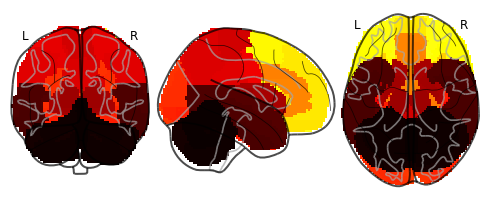

In [ ]:
#https://www.gin.cnrs.fr/en/tools/aal/
from nilearn import plotting
from nilearn import datasets
# AAL 116
aal = datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)
atlas_img = aal.maps # Descarga y devuelve la plantilla AAL para SPM 12. Este atlas es el resultado de una parcelación anatómica automatizada del volumen T1 de alta resolución de un solo sujeto normalizado espacialmente proporcionado por el Instituto Neurológico de Montreal (MNI) (DL Collins et al., 1998, Trans. Med. Imag. 17, 463- 468, PubMed).
plotting.plot_glass_brain(atlas_img)#"/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/Codigos Matlab/roi_mnifsl.img")   


In [ ]:
#9.4.10.6. Trazar regiones extraídas para una sola red específica ¶
# First, we plot a network of index=4 without region extraction (left plot)
from nilearn import image

img = image.index_img("/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/Codigos Matlab/RSN_full.mat", 4)
coords = plotting.find_xyz_cut_coords(img)
display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')

ImageFileError: ignored

In [ ]:
from nilearn import plotting

CONN=np.zeros([L,L])
#for t in range(0,L):
#    CONN[np.asarray(xw.astype(int)[t]-1), np.asarray(yw.astype(int)[t]-1)]=fimport
CONN[ np.asarray(xw.astype(int)-1), np.asarray(yw.astype(int)-1)]=fimport

mat = spio.loadmat('crossley_nodes_new.mat')
nodes=mat['crossley_nodes_new']
#3D Plots of connectomes
#plotting.view_connectome(CONN+CONN.T, nodes[:,0:3], threshold=0.007)   


In [ ]:
from nilearn import plotting

CONN=np.zeros([nf,nf])
CONN[ np.asarray(XW.astype(int)-1), np.asarray(YW.astype(int)-1)]=fimport

mat = spio.loadmat('drive/My Drive/Colab Notebooks/crossley_nodes_new.mat')

nodes=mat['crossley_nodes_new']
plotting.view_connectome(CONN+CONN.T, nodes[:,0:3],linewidth=10,node_size=6, edge_threshold=0.01)  

In [ ]:
from matplotlib import pyplot as pl

pl.clf()
#pl.hold(1)

################################################################################
#                              RECOPILACION DE DATOS
################################################################################
import csv

id_carpeta = 'DMN'
drive_name = '/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/Reportes (creado sep 2020)/'

weeks =['week0','week1','week2','week3','week5','week12','week24']
Nff = [1, 2, 4, 8, 16, 32, 64, 128]
n = 100      # numero de iteraciones 


results_plot_auc(weeks, Nff, n, drive_name, id_carpeta )



NameError: ignored

<Figure size 432x288 with 0 Axes>

###*histograma*

(2,)


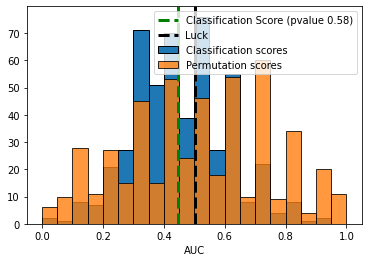

(2,)


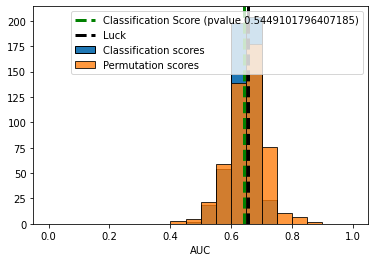

(2,)


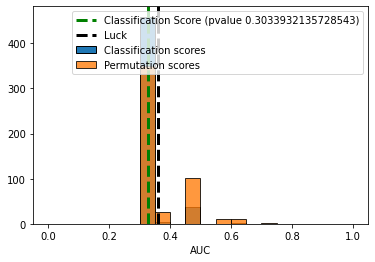

In [ ]:

hum1=AUC#mean_auc
hum2=ACCU#mean_accu
hum3=PREC#mean_prec
pauc=np.sum((mean_auc_s>hum1)*1)/(len(mean_auc_s))
paccu=np.sum((mean_accu_s>hum2)*1)/(len(mean_accu_s)+1)
pprec=np.sum((mean_prec_s>hum3)*1)/(len(mean_prec_s)+1)

metric=[mean_auc, mean_accu, mean_prec]
metric_s=[mean_auc_s, mean_accu_s, mean_prec_s]

p=[pauc, paccu, pprec]

for j in [0,1,2]:
  # histogramas
  #plt.hist(mean_auc, 8,range = (0,1), label='Classification scores',alpha=1, edgecolor='black')
  #plt.hist(mean_auc_s, 8, range = (0,1), label='Permutation scores',alpha=0.8, edgecolor='black')
  #metric = mean_auc ; metric_s = mean_auc_s
  #metric = mean_accu; metric_s = mean_accu_s
  #metric = mean_prec; metric_s = mean_prec_s
  plt.figure()
  plt.hist(metric[j], np.array(range(0,21))/20, label='Classification scores',alpha=1, edgecolor='black')
  plt.hist(metric_s[j],  np.array(range(0,21))/20, label='Permutation scores',alpha=0.8, edgecolor='black')

  ylim = plt.ylim()
  print(np.asarray(ylim).shape)
  plt.axvline(x=np.mean(metric[j]), color='g', linestyle='--', linewidth=3,label='Classification Score'' (pvalue %s)' % p[j])
  plt.axvline(x=np.mean(metric_s[j]), color='k', linestyle='--', linewidth=3,label='Luck')
  plt.ylim(ylim)
  plt.legend()
  plt.xlabel('AUC')

  #plt.title('GBM({}): p-valor= {}, AUC= {:.4f}, AUC shuffle = {:.4f},\n Num.features= {}, Nummero de iteraciones= {}'.format(week, AUC, AUC_S, Nf, n))

  plt.show()

  #plt.savefig('drive/My Drive/Colab Notebooks/{}.png'.format(respuesta))

auc  0.07592407592407592
accuracy  0.06893106893106893
precision  0.1088911088911089


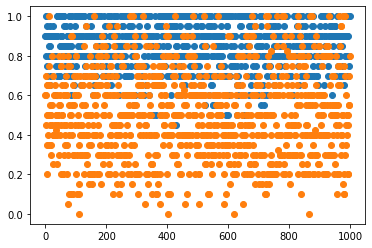

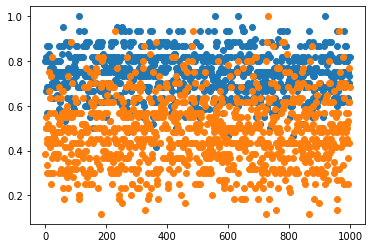

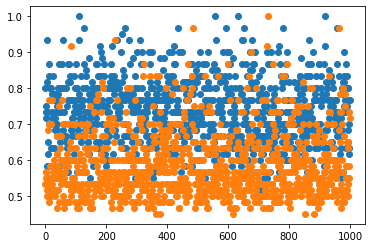

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np 

#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = AUC, scale = STD_AUC)
rv1 = norm(loc = AUC_S, scale = STD_AUC_S)


x = np.arange(-1, 3, .01)

#plot the pdfs of these normal distributions 
#plt.plot(x, rv.pdf(x), x, rv1.pdf(x))
plt.plot(mean_auc,'o')
plt.plot(mean_auc_s,'o')
plt.figure()
plt.plot(mean_accu,'o')
plt.plot(mean_accu_s,'o')
plt.figure()
plt.plot(mean_prec,'o')
plt.plot(mean_prec_s,'o')

std_auc = np.std(mean_auc_s)    
hum=mean_auc
print('auc ',(np.sum((mean_auc_s>hum)*1))/(len(mean_auc_s)))
print('accuracy ',(np.sum((mean_accu_s>mean_accu)*1)+1)/(len(mean_accu_s)+1))
print('precision ',(np.sum((mean_prec_s>mean_prec)*1)+1)/(len(mean_prec_s)+1))

In [ ]:
from sklearn.metrics import roc_curve

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
idx = np.arange(0, len(y))

for j in np.random.randint(0, high=10000, size=10):
    np.random.shuffle(idx)
    kf = KFold(n=len(y), n_folds=10, random_state=j)

    for i, (train, test) in enumerate(kf):
        model = LogisticRegression().fit(X[idx][train], y[idx][train])
        y_score = model.predict_proba(X[idx][test])
        fpr, tpr, _ = roc_curve(y[idx][test], y_score[:, 1])

        plt.plot(fpr, tpr, 'b', alpha=0.05)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [ ]:
# Grafico de los 20 mas importantes Feature importances
M = fsize
A = np.flip(np.argsort(fimport))
fimport_p = fimport[A[0:M]]

XW_o = XW[A[0:M]]
YW_o = YW[A[0:M]]
excel = np.vstack((fimport_p,  XW_o.astype(int), YW_o.astype(int))).T
np.savetxt('/content/drive/My Drive/Colab Notebooks/Debora (limipieza)/fimportances.csv', excel, delimiter=',')

#print(A)


In [ ]:
print(np.asarray(XW.astype(int)))
np.size(np.asarray(XW.astype(int)))
CONN[ np.asarray(xxw.astype(int)-1), np.asarray(yyw.astype(int)-1)]=fimport

[136 136 136 ... 401 401 401]


NameError: ignored

esta es xv [[136. 136. 136. ... 136. 136. 136.]
 [140. 140. 140. ... 140. 140. 140.]
 [201. 201. 201. ... 201. 201. 201.]
 ...
 [398. 398. 398. ... 398. 398. 398.]
 [400. 400. 400. ... 400.   0. 400.]
 [401. 401. 401. ... 401. 401.   0.]]
[136. 136. 136. ... 401. 401. 401.] (4400,)
[  1.   2.   3. ... 398. 399. 400.] (4400,)
esta es A (11, 401)


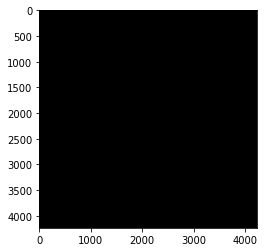

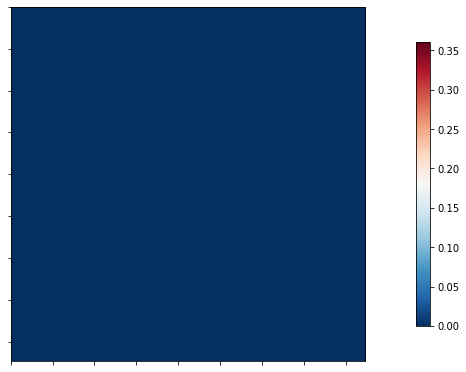

In [ ]:
# plots de correlaciones
from nilearn import plotting

NombreColor='gray';

#fig, ax = plt.plot() es yv',yv)
print('esta es xv',xv)

xw=xv[np.nonzero(xv)]
yw=yv[np.nonzero(yv)]

print(xw,xw.shape)
print(yw,yw.shape)

#print(xw.astype(int))
################################################################################
## Desenrrollamos la matriz
A=cORR[:,:,0]
#pongo ceros en la diagonal
np.fill_diagonal(A, 0) 
#me quedo con las filas que me interesan y elimino la dimension de mas
A=np.squeeze(A[lab,:])
print('esta es A',A.shape)
#Elimino la diagonal y lo 
plt.imshow(CONN+CONN.T,  cmap=plt.get_cmap(NombreColor), vmin=0,vmax=np.max(CONN))

#colores
plotting.plot_matrix(CONN+CONN.T)


(300, 3)


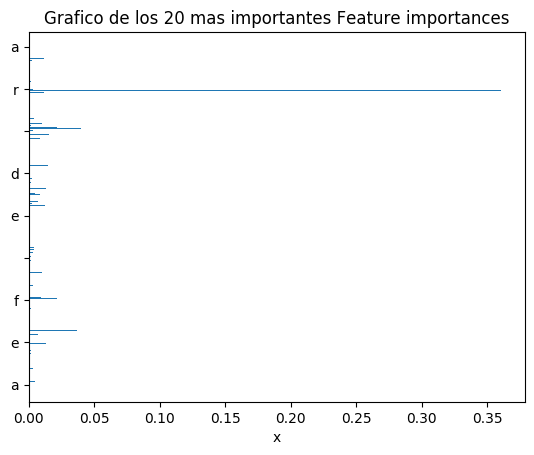

In [ ]:
print((np.vstack((fimport_p, XW_o, YW_o)).T ).shape)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
#people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
#y_pos = np.arange(YW_o)

ax.barh(YW_o,fimport_p,  align='center')
#ax.set_yticks(y_pos)
ax.set_yticklabels('par de features')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('x')
ax.set_title('Grafico de los 20 mas importantes Feature importances')

plt.show()

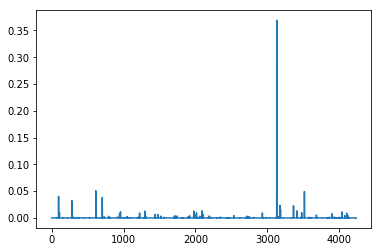

In [ ]:
%matplotlib inline

plt.plot(fimport)
plt.show() 

In [ ]:
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.naive_bayes import *
import numpy as np
import pandas as pd

# Leo data
data = pd.read_csv('datos_facu.csv')
X=data['positive_rate neutral_rate negative_rate'.split()].values
y=data.success.values==True

# Classifier config
clf = lambda : GaussianNB([0.4,0.6])

# Results
print('precision',cross_val_score(clf(),X,y,cv=7,scoring='precision').mean())
print('roc_auc',cross_val_score(clf(),X,y,cv=7,scoring='roc_auc').mean())

FileNotFoundError: ignored

In [ ]:
################################################################################
#                             LABELS (ETIQUETAS)
################################################################################

# Función para obtener los labels a partir del codigo nuevo 
# (puede requerir codigo del anterior si se quieren muchisimos labels)
#-------------------------------------------------------------------------------

# zones debe ser un str ('string') o una lista de str (['string1','string2'])
# con los nombres clave de cada zona
# la salida es una lista de numeros de los labels (lab-1) o codifo -1 (all labels)
# o codigo -2 (error)

def get_labels(zones):
  
  # lista de labes mapeados con nombres simbolicos de las zona de interes
  switcher = {

    # labels de zonas individuales
    #-------------------------------
    # Amigdala (level ?)
    'amg': [35, 94], 

    # Hipocampo (level ?)
#    'hipo': [136, 140, 201, 202],  #202 y 201 estaban mal (ahora son parahipocampo_R) probar con este tb
    'hipo': [135, 136, 140, 141],  # nuevo

    # Anterior Cingulate (level ?)
#    'antcyg': [2, 3, 190, 398, 399, 400, 401],  # 399 agregado
    'antcyg': [1, 2, 3, 398, 399, 400, 401],  # nuevo

    # Cingulate gyrus (level ?)
    'cyngys': [4, 6, 7, 8, 10, 12, 13, 14, 15],  ## cigulate MID y POST ??
    
    # límbico (level ?)
    'limbic': [2, 3, 4, 6, 7, 8, 12, 13, 14, 15, 35, 123, 124, 136, 151, 157, 
               159, 190, 199, 201, 202, 203, 210, 398, 400, 401],
    
    # frontal (level ?)
    'frontal': [1, 5, 9, 10, 11, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 
     39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 
     59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 
     78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 98, 
     100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 
     116, 117, 118, 119, 120, 134, 194, 195, 196, 197, 198, 230, 233, 235, 237, 
     238, 239, 241, 245, 265, 247, 250, 251, 252, 253, 254, 255, 256, 257, 258, 
     259, 260, 261, 262, 263, 264, 266, 295, 296, 297, 298, 302, 303, 304, 305, 
     306, 307, 308, 309, 310, 311, 312, 313, 314],
    
    # superior frontal .. (level ?)
    'sfg': [52,59,63,65,67,69,78,85,86,87,88,91,92,93,98,102,103,104,105,108,
              110,113,115,117,118,119,120,194,254,305,306,307,308,311,313,314],  
    
    # superior middle .. (level ?)
    'mfg': [ 29,31,33,36,39,41,49,55,56,57,60,61,62,64,66,68,70,71,72,73,74,
              75,76,77,79,80,81,82,83,84,90,111,112,114,116,255,256,257,263,266],
    
    # inferior frontal .. (level ?)
    'ifg': [25,26,28,32,34,37,38,40,42,44,45,46,47,48,50,109,250,251,252,260], 

    # todos los labels
    'all': range(1,402) # todos : [1, 2, 3, ...., 401]
  }
  
  # si "zones" no es una lista (o sea, es un str), la convierto en lista
  if isinstance(zones, list) == False:
    zones = [zones]

  # Cargamos el primer label ingresados en "zones" 
  labels = switcher.get( zones[0],["No"])    # leemos label                        que es el no???????????????


  # Cargamos y acumulamos los restantes labels (si "zones" posee mas de uno)
  if len(zones) > 1:  # zones tiene mas de un elemento?  
    for i in range(1,len(zones)):
      newlabs = switcher.get( zones[i], ["No"])       # leemos label
      #print(newlabs)
      labels = np.concatenate( (labels, newlabs) )  # concatemaos labels

  # Chequeamos si las zonas son correctas, sino devuelve codigo de error (-1)
  for i in range(0,len(labels)):
    if labels[i]=="No": 
       print('No se reconoce alguna de las zonas ingresadas!')
       return -1  

  # retorna:
  # [...] labels elegidos
  # -1 codigo de error (label erroneo)
  return np.unique(np.asarray(labels)-1)
  
